# Noisy-TrajGAN

In [1]:
%load_ext autoreload
%autoreload 2
import os


RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # Move to default colab folder
    %cd /content
    # Check if repository is already cloned
    if not os.path.isdir("stg"):
        # Clone repository
        !git clone https://github.com/erik-buchholz/SoK-TrajGen.git stg
    # Change to repository directory
    %cd stg
    # Only install requirements not already installed by Colab
    !pip install opacus
    # SLOW: Only execute the following line if you encounter an error regarding a package not being installed
    # !pip install -r requirements.txt
else:
    import sys
    sys.path.append('..')  # Required for finding the `stg` module

In [2]:
import logging
import torch

import pandas as pd
from torch.utils.data import DataLoader
from stg.datasets.padding import pad_feature_first

from stg.utils.logger import configure_root_loger
from stg.utils import helpers
from stg.datasets.base_dataset import DatasetModes, TrajectoryDataset
from stg.models import Noise_TrajGAN
# Load PyTorch Dataset
from stg.datasets.fs_nyc import FSNYCDataset, PATH_ALL
from stg.models.utils import visualize_mnist_sequential, visualize_trajectory_samples
from stg.datasets import get_dataset, Datasets


configure_root_loger(logging_level=logging.INFO)

<RootLogger root (INFO)>

In [3]:
# Parameters
BATCH_SIZE = 10

GPU = 0

## MNIST Sequential

In [4]:
# Load dataset
mnist_dataset: TrajectoryDataset = get_dataset(dataset_name=Datasets.MNIST_SEQUENTIAL, mode=DatasetModes.TRAIN, latlon_only=True, return_labels=True)
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
sample_batch = next(iter(mnist_dataloader))[0]
print(f"Shape of one Batch: {sample_batch.shape}")

Shape of one Batch: torch.Size([10, 28, 28])


In [5]:
features_mnist = ['mnist']
vocab_size_mnist = {'mnist': 28}
embedding_size_mnist = {'mnist': 28}
MODEL_NAME = "Noise_TrajGAN_MNIST_SEQUENTIAL"

NOISE_DIM = 100
LATENT_DIM = 100
BETA = (0.5, 0.999)
LR_G = 1e-3
LR_D = 1e-3
WGAN = True
WGAN_GP = True
WGAN_LP = True
N_CRITIC = 5


# Create Model
mnist_gan = Noise_TrajGAN(
    features=features_mnist,
    vocab_size=vocab_size_mnist,
    embedding_size=embedding_size_mnist,
    noise_dim=NOISE_DIM,
    latent_dim=LATENT_DIM,
    name=MODEL_NAME,
    beta1=BETA[0],
    beta2=BETA[1],
    lr_g=LR_G,
    lr_d=LR_D,
    wgan=WGAN,
    gradient_penalty=WGAN_GP,
    lipschitz_penalty=WGAN_LP,
    gpu=GPU
)

In [6]:
# Train Model
N_EPOCHS = 100
TRAIN = False
if TRAIN:
    mnist_gan.training_loop(
        dataloader=mnist_dataloader,
        dataset_name="MNIST",
        epochs=N_EPOCHS,
        n_critic=N_CRITIC,
        notebook=True,
        tensorboard=False,
        n_generator=1,
        save_freq=20
    )
else:
    try:
        mnist_gan.load_parameters(epoch=N_EPOCHS)
    except FileNotFoundError:
        print("Model not found")

[2024-02-04 15:34:01,842][INFO   ] Loaded parameters from /home/erik/project2/parameters/Noise_TrajGAN_MNIST_SEQUENTIAL/0100_COM.pth (trajGAN.py:83) 


25 (28, 28)


/tmp/ipykernel_106731/673243135.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  generated = torch.tensor(generated)


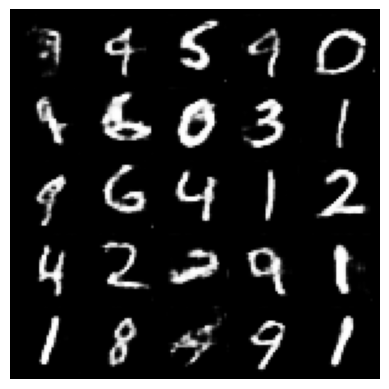

In [7]:
# Generate
NUM = 25
generated = mnist_gan.generate(num=NUM, max_length=28, to_numpy=True)[0]
print(len(generated), generated[0].shape)
generated = torch.tensor(generated)

visualize_mnist_sequential(generated, batches_done=0, notebook=True, )

## Foursquare Dataset

In [8]:
N_EPOCHS = 300
spatial_columns = ['lon', 'lat']

# Compute reference point and scaling factor basd on all data
# Note that this is a privacy leakage in some sense, however, the original implementation does it this way, and we intend to stay as close as possible to the original implementation.
# In theory, it would be preferable to compute the reference point and scaling factor based on the insensitive data only. 
_all = pd.read_csv(PATH_ALL)
ref = helpers.get_ref_point(_all[spatial_columns])
sf = helpers.get_scaling_factor(_all[spatial_columns], ref)

fs_dataset = FSNYCDataset(
    mode=DatasetModes.TRAIN,
    spatial_columns=spatial_columns,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    reference_point=ref,
    scale_factor=sf,
)

print("Training Samples:\t\t\t\t", len(fs_dataset))
print("Reference Point:\t\t\t\t", ref)
print("Scaling Factor:\t\t\t\t\t", sf)

fs_loader = DataLoader(
    fs_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=pad_feature_first
)
print("Number of Batches per epoch:\t", len(fs_loader))
print("Number of Epochs:\t\t\t\t", N_EPOCHS)
print("Total Number of Batches:\t\t", len(fs_loader) * N_EPOCHS)

# Expected Output:
# Reference Point:	 [-73.977705979516, 40.76959209333479]
# Scaling Factor:    [0.29193802048399675, 0.21873962593050322]

[2024-02-04 15:34:02,351][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/train_latlon.csv'. (fs_nyc.py:85) 
Training Samples:				 2052
Reference Point:				 [-73.97770598  40.76959209]
Scaling Factor:					 [0.29193802 0.21873963]
Number of Batches per epoch:	 205
Number of Epochs:				 300
Total Number of Batches:		 61500


In [9]:
MODEL_NAME = "Noise_TrajGAN_FS"

NOISE_DIM = 100
LATENT_DIM = 100
BETA = (0.5, 0.999)
LR_G = 1e-3
LR_D = 1e-3
WGAN = True
WGAN_GP = True
WGAN_LP = True
N_CRITIC = 5


# Create Model
fs_gan = Noise_TrajGAN(
    noise_dim=NOISE_DIM,
    latent_dim=LATENT_DIM,
    name=MODEL_NAME,
    beta1=BETA[0],
    beta2=BETA[1],
    lr_g=LR_G,
    lr_d=LR_D,
    wgan=WGAN,
    gradient_penalty=WGAN_GP,
    lipschitz_penalty=WGAN_LP,
    gpu=GPU
)

In [10]:
TRAIN = False
N_EPOCHS = 300

if TRAIN:
    fs_gan.training_loop(
        dataloader=fs_loader,
        dataset_name="FS",
        epochs=N_EPOCHS,
        n_critic=N_CRITIC,
        notebook=True,
        tensorboard=False,
        n_generator=1,
        save_freq=20
    )
else:
    try:
        fs_gan.load_parameters(epoch=N_EPOCHS)
    except FileNotFoundError:
        print("Model not found")

[2024-02-04 15:34:04,087][INFO   ] Loaded parameters from /home/erik/project2/parameters/Noise_TrajGAN_FS/0300_COM.pth (trajGAN.py:83) 


1000 (28, 2)
1000 torch.Size([44, 2])


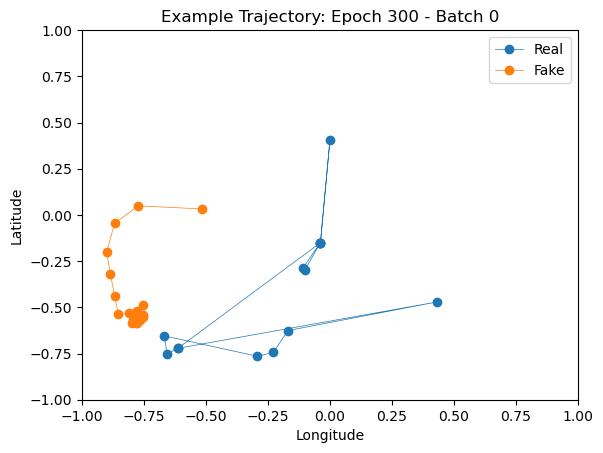

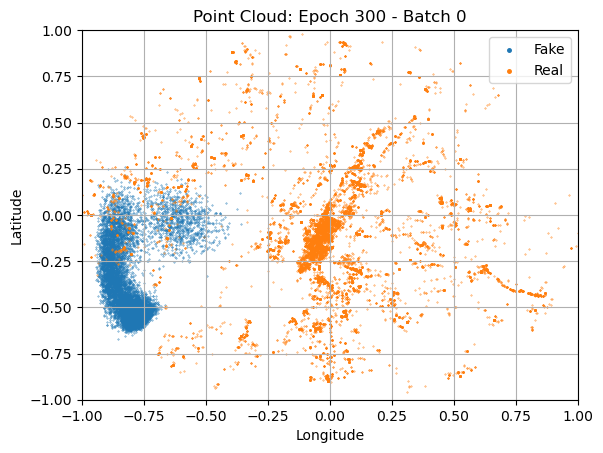

In [11]:
# Generate
NUM = 1000
generated = fs_gan.generate(num=NUM, max_length=28, to_numpy=True)[0]
print(len(generated), generated[0].shape)
generated = torch.tensor(generated)

# Sample same number of trajectories as in the original dataset
real = [fs_dataset[i][0] for i in range(NUM)]
print(len(real), real[0].shape)

visualize_trajectory_samples(gen_samples=generated, real_samples=real, notebook=True, epoch=N_EPOCHS, batch_i=0)


## GeoLife Dataset

In [12]:
# Load dataset
gl_dataset: TrajectoryDataset = get_dataset(dataset_name=Datasets.GEOLIFE, mode=DatasetModes.ALL, latlon_only=False, return_labels=False)
MAX_LENGTH = gl_dataset.max_len  # Max length of a sequence
gl_dataloader = DataLoader(gl_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=pad_feature_first)
sample_batch = next(iter(gl_dataloader))
for i, _ in enumerate(sample_batch):
    print(f"Shape of Feature {i}: {sample_batch[i].shape}")

[2024-02-04 15:34:05,041][WARNING] Make sure the reference point and scale factor computed during pre-processing are used! (geolife.py:122) 
[2024-02-04 15:34:05,043][INFO   ] Reading trajectories from '/home/erik/project2/data/geolife_FIFTH-RING_5_60_200_TRUNCATE'. (geolife.py:129) 
Shape of Feature 0: torch.Size([10, 200, 2])
Shape of Feature 1: torch.Size([10, 200, 24])
Shape of Feature 2: torch.Size([10, 200, 7])


In [13]:
MODEL_NAME = "Noise_TrajGAN_GEOLIFE"

NOISE_DIM = 100
LATENT_DIM = 100
BETA = (0.5, 0.999)
LR_G = 1e-3
LR_D = 1e-3
WGAN = True
WGAN_GP = True
WGAN_LP = True
N_CRITIC = 5

print("Features:", gl_dataset.features)

# Create Model
geolife_gan = Noise_TrajGAN(
    features=gl_dataset.features,
    noise_dim=NOISE_DIM,
    latent_dim=LATENT_DIM,
    name=MODEL_NAME,
    beta1=BETA[0],
    beta2=BETA[1],
    lr_g=LR_G,
    lr_d=LR_D,
    wgan=WGAN,
    gradient_penalty=WGAN_GP,
    lipschitz_penalty=WGAN_LP,
    gpu=GPU
)

Features: ['latlon', 'hour', 'day']


In [14]:
TRAIN = False
N_EPOCHS = 100

if TRAIN:
    geolife_gan.training_loop(
        dataloader=gl_dataloader,
        dataset_name="GEOLIFE",
        epochs=N_EPOCHS,
        n_critic=N_CRITIC,
        notebook=True,
        tensorboard=False,
        n_generator=1,
        save_freq=20
    )
else:
    try:
        geolife_gan.load_parameters(epoch=N_EPOCHS)
    except FileNotFoundError:
        print("Model not found")

[2024-02-04 15:34:05,511][INFO   ] Loaded parameters from /home/erik/project2/parameters/Noise_TrajGAN_GEOLIFE/0100_COM.pth (trajGAN.py:83) 


1000 (200, 2)
1000 torch.Size([147, 2])


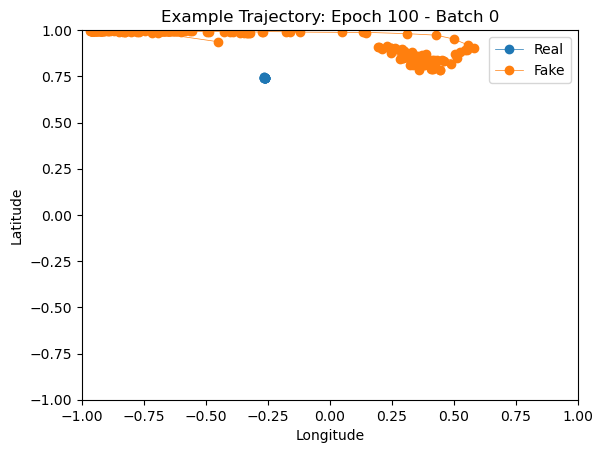

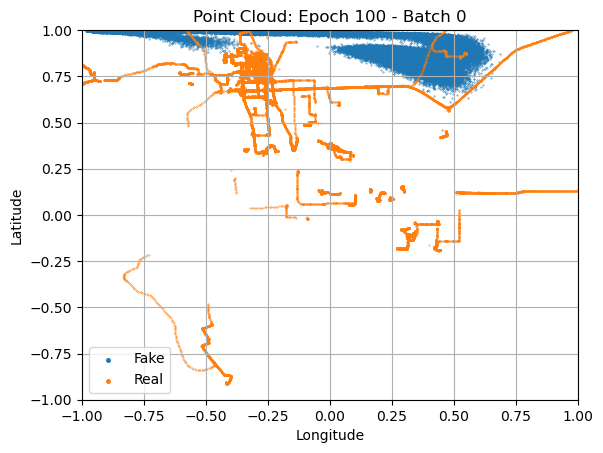

In [15]:
# Generate
NUM = 1000
generated = geolife_gan.generate(num=NUM, max_length=gl_dataset.max_len, to_numpy=True)[0]
print(len(generated), generated[0].shape)
generated = torch.tensor(generated)

# Sample same number of trajectories as in the original dataset
real = [gl_dataset[i][0] for i in range(NUM)]
print(len(real), real[0].shape)

visualize_trajectory_samples(gen_samples=generated, real_samples=real, notebook=True, epoch=N_EPOCHS, batch_i=0)